<a href="https://colab.research.google.com/github/adamzki99/nlp-zlatan/blob/feature%2Fdoc2vec_approach/nlp_zlatan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia

/content/drive/MyDrive/nlp-datasets/wizard_of_wikipedia


# Reading the dataset

In [7]:
import json

with open('data.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


# Data exploration


In [8]:
len(data)

22311

In [9]:
data[:5]

[{'chosen_topic': 'Science fiction',
  'persona': 'i enjoy movies about aliens invading the earth.',
  'wizard_eval': 5,
  'dialog': [{'speaker': '0_Wizard',
    'text': "I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.",
    'checked_sentence': {'chosen_Science_fiction_0': 'Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.'},
    'checked_passage': {'chosen_topic_0_Science_fiction': 'Science fiction'},
    'retrieved_passages': [{'Hyperspace (science fiction)': ['Hyperspace is a faster-than-light (FTL) method of traveling used in science fiction.',
       'It is typically described as an alternative "sub-region" of space co-existing with our own universe which may be 

In [10]:
data[0].keys()

dict_keys(['chosen_topic', 'persona', 'wizard_eval', 'dialog', 'chosen_topic_passage'])

In [11]:
data[0]['chosen_topic_passage']

['Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.',
 'Science fiction often explores the potential consequences of scientific and other innovations, and has been called a "literature of ideas".',
 'It usually avoids the supernatural, unlike the related genre of fantasy.',
 'Historically, science-fiction stories have had a grounding in actual science, but now this is only expected of hard science fiction.',
 'Science fiction is difficult to define, as it includes a wide range of subgenres and themes.',
 'Hugo Gernsback, who suggested the term "scientifiction" for his "Amazing Stories" magazine, wrote: "By \'scientifiction\' I mean the Jules Verne, H. G. Wells and Edgar Allan Poe type of story—a charming romance intermingled with scientific fact and prophetic vision..

In [12]:
data[0].keys()

dict_keys(['chosen_topic', 'persona', 'wizard_eval', 'dialog', 'chosen_topic_passage'])

In [13]:
print(data[0]['persona'])
print(data[0]['chosen_topic'])

i enjoy movies about aliens invading the earth.
Science fiction


Dictionary keys of Wizard

In [14]:
data[0]['dialog'][0].keys()

dict_keys(['speaker', 'text', 'checked_sentence', 'checked_passage', 'retrieved_passages', 'retrieved_topics'])

Dictionary keys of Apprentice

In [15]:
data[0]['dialog'][1].keys()

dict_keys(['speaker', 'text', 'retrieved_passages', 'retrieved_topics'])

In [16]:
for i in range(10):
    print(i, ":", data[0]['dialog'][i]['text'])

0 : I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.
1 : I'm a huge fan of science fiction myself! 
2 : Awesome! I really love how sci-fi storytellers focus on political/social/philosophical issues that would still be around even in the future. Makes them relatable.
3 : I agree. One of my favorite forms of science fiction is anything related to time travel! I find it fascinating.
4 : It's not quite sci-fi, but my favorite version of time travel is in Harry Potter and the Prisoner of Azkaban. Breaks zero logical rules.
5 : And that's difficult to do when dealing with time travel. I actually haven't seen the latest Harry Potter movies. Guess it's time to check them out!
6 : If you really want a look at the potential negative consequences of scientific innovation, what you should check out is the TV show Fringe. Incredibly well written.
7 : Thank you for the suggestion, I will definitely c

In [17]:
for i in range(10):
    print(i, ":", data[0]['dialog'][i]['retrieved_topics'])

0 : ['Hyperspace (science fiction)', 'Science fiction', 'History of science fiction', 'Science fiction film', 'Time travel', 'List of starships in Stargate', 'History of US science fiction and fantasy magazines to 1950']
1 : ['Science fiction', 'History of science fiction', 'Isaac Asimov', 'U.S. television science fiction', 'History of US science fiction and fantasy magazines to 1950', 'Starstruck (comics)', 'LGBT themes in speculative fiction']
2 : ['Oddworld Inhabitants', 'Legalism (Chinese philosophy)', 'Sci-Fi on the Rock', 'Starstruck (comics)', 'The Spirit of the Age', 'Science fiction film', 'Music of the Marvel Cinematic Universe']
3 : ['Science fiction', 'Science fiction film', 'History of science fiction', 'Time travel', 'Parallel universes in fiction', 'Alternate history', 'Time travel in fiction']
4 : ['Magical objects in Harry Potter', 'List of supporting Harry Potter characters', 'Harry Potter', 'Order of the Phoenix (fictional organisation)', 'Places in Harry Potter', 'M

In [18]:
for i in range(10):
    print(i, ":", data[0]['dialog'][i]['retrieved_passages'])

0 : [{'Hyperspace (science fiction)': ['Hyperspace is a faster-than-light (FTL) method of traveling used in science fiction.', 'It is typically described as an alternative "sub-region" of space co-existing with our own universe which may be entered using an energy field or other device.', 'As seen in most fiction hyperspace is most succinctly described as a "somewhere else" within which the laws of general and special relativity decidedly do "not" apply – especially with respect to the speed of light being the cosmic speed limit.', 'Entering and exiting said "elsewhere" thus directly enables travel near or faster than the speed of light – almost universally with the aid of extremely advanced technology.']}, {'Science fiction': ['Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrest

## Exploring uniqe types

Exploring how many uniqe "chosen_topic"s, "persona"s and "wizard_eval"s there are in the dataset

In [19]:
topics = []
personas = []
wizardEvals = []

for entry in data:

  topics.append(entry['chosen_topic'])
  personas.append(entry['persona'])
  wizardEvals.append(entry['wizard_eval'])

# Making the list containing only uniqe items
topics = list(set(topics))
personas = list(set(personas))
wizardEvals = list(set(wizardEvals))

print("topic:", len(topics), "persona:", len(personas), "wizard_eval:", len(wizardEvals))

topic: 1365 persona: 1557 wizard_eval: 7


Why are there more than 5 different "wizard_eval"s? The paper only mentions a rating from 1-5. What are the other 2?

In [20]:
for entry in wizardEvals:
  print(wizardEvals[entry] )
#what's up with -1 and 0? In paper only ratings from 1 to 5 are mentioned

0
1
2
3
4
5
-1


How often does each rating occur in "wizard_eval"s? Visualize all the different instances in a histogram

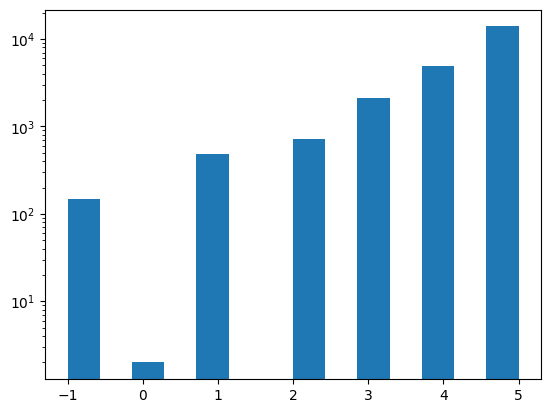

In [21]:
import matplotlib.pyplot as plt
import numpy as np

wEval = []

for entry in data:
    wEval.append(entry['wizard_eval'])

plt.hist(wEval, bins=2*len(set(wEval))) #the number of bins can probably be improved to look nicer
plt.yscale('log')
plt.show()

In [22]:
# What is a topic?

topics[:10]

['Spitz',
 'Punk rock',
 'Game of Thrones',
 'Moped',
 'Honda Civic',
 'Chef',
 'Track and field',
 'Unicycle',
 'Music festival',
 'Sports car']

In [23]:
# What is a persona?

personas[:10]

['i drive a restored mustang.',
 'i was adopted.',
 'i love ergonomic keyboards and chairs.',
 'i am studying to be a dentist.',
 'i like to go on long hikes.',
 'i am bipolar.',
 'i just took a trip to london.',
 'i am a school teacher.',
 'i can play the piano.',
 'i love to watch game shows.']

#Doc2Vec Approach (Farid)

##Import necessary tools

In [35]:
%pip install --upgrade gensim
import gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Install blas to reduce computation time

In [36]:
import scipy.linalg
from scipy.linalg import blas
#from scipy.linalg.blas import cblas
%pip install numpy pyblas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyblas: filename=pyblas-0.0.10-py3-none-any.whl size=52460 sha256=4fef4b82044757281ecb66c36cd1d28751e847c910250d57f4e321b3444cc65f
  Stored in directory: /root/.cache/pip/wheels/76/c5/67/76acf3796d4a2c1d43a7a02273e0a812bb53c7a31a258f1c47
Successfully built pyblas


##Import Data

In [37]:
import json

with open('data.json', 'r') as file:
    json_data = file.read()
    data = json.loads(json_data)

print('Datatype:', type(data))

Datatype: <class 'list'>


##Quick look at the Data

In [38]:
# This dataframe is never used, but it is useful for looking at the dataset

import pandas as pd

df = pd.DataFrame(data)
df

,chosen_topic,persona,wizard_eval,dialog,chosen_topic_passage
0,Science fiction,i enjoy movies about aliens invading the earth.,5,"[{'speaker': '0_Wizard', 'text': 'I think scie...",[Science fiction (often shortened to SF or sci...
1,Internet access,i have high speed internet.,5,"[{'speaker': '0_Apprentice', 'text': 'Can you ...",[Internet access is the ability of individuals...
2,Pharmacist,i am a pharmacist.,5,"[{'speaker': '0_Apprentice', 'text': 'I am jus...","[Pharmacists, also known as chemists (Commonwe..."
3,Homebrewing,i brew my own beer.,5,"[{'speaker': '0_Apprentice', 'text': 'I have h...",[Homebrewing is the brewing of beer on a small...
4,Red hair,i have red hair.,5,"[{'speaker': '0_Apprentice', 'text': 'red hair...",[Red hair (or ginger hair) occurs naturally in...
...,...,...,...,...,...
22306,Green,my favorite color is green.,4,"[{'speaker': '0_Wizard', 'text': 'So, you know...",[Green is the color between blue and yellow on...
22307,Motivation,i have trouble getting motivated.,2,"[{'speaker': '0_Wizard', 'text': 'I swear, it ...",[Motivation is the reason for people's actions...
22308,List of national parks of the United States,i like to visit national parks.,5,"[{'speaker': '0_Apprentice', 'text': 'I've bee...",[The United States has 59 protected areas know...
22309,Kendrick Lamar,i listen to rap.,3,"[{'speaker': '0_Wizard', 'text': 'Kendrick Lam...","[Kendrick Lamar Duckworth (born June 17, 1987)..."


##Preparing the Data

###Preparing the training set

We first have to decide which Data we want to use to train the model aka what goal are we trying to achieve.
As we want to retrieve the correct passage for each turn we should probably train the model on the passages given and then try to retrieve the chosen passage given a sentence from the dialogue

In [39]:
import pandas as pd

pd.DataFrame(data[0]["chosen_topic_passage"])

,0
0,Science fiction (often shortened to SF or sci-...
1,Science fiction often explores the potential c...
2,"It usually avoids the supernatural, unlike the..."
3,"Historically, science-fiction stories have had..."
4,"Science fiction is difficult to define, as it ..."
5,"Hugo Gernsback, who suggested the term ""scient..."
6,They supply knowledge... in a very palatable f...


So we want to take all the sentences from each "chosen_topic_passage" and separately use those as the training data

In [40]:
passages = [[passage for passage in sample['chosen_topic_passage']] for sample in data]
pd.DataFrame(passages[:2])

,0,1,2,3,4,5,6
0,Science fiction (often shortened to SF or sci-...,Science fiction often explores the potential c...,"It usually avoids the supernatural, unlike the...","Historically, science-fiction stories have had...","Science fiction is difficult to define, as it ...","Hugo Gernsback, who suggested the term ""scient...",They supply knowledge... in a very palatable f...
1,Internet access is the ability of individuals ...,"Various technologies, at a wide range of speed...","Internet access was once rare, but has grown r...","In 1995, only percent of the world's populatio...","By the first decade of the 21st century, many ...","The Internet developed from the ARPANET, which...",Use by a wider audience only came in 1995 when...


Now we have a nested list of lists -> let's unfold that list in a way that the nested entries of those lists are their own entries

In [41]:
sentences = []
for i in passages:
  for entry in i:
    sentences.append(entry)
    
pd.DataFrame(sentences[:10])

,0
0,Science fiction (often shortened to SF or sci-...
1,Science fiction often explores the potential c...
2,"It usually avoids the supernatural, unlike the..."
3,"Historically, science-fiction stories have had..."
4,"Science fiction is difficult to define, as it ..."
5,"Hugo Gernsback, who suggested the term ""scient..."
6,They supply knowledge... in a very palatable f...
7,Internet access is the ability of individuals ...
8,"Various technologies, at a wide range of speed..."
9,"Internet access was once rare, but has grown r..."


Let's check our dataset for duplicates

In [42]:
print(f"Dataset with duplicates: {len(sentences)}")

#Let's turn the list into a dictionary and then back into a list to eliminate duplicates
unique_sentences = list(dict.fromkeys(sentences))
print(f"Cleaned up Dataset: {len(unique_sentences)}")

Dataset with duplicates: 210354
Cleaned up Dataset: 12702


*We reduced our dataset to 6% of the original one!*

###Preparing the test set

For the test set we need all the sentences created by the wizard which are based on sentences from Wikipedia articles aka the training set so we can then test the similarity between those sentences and the training set.
This way we want to be able to recover the sentence that was used to craft a response given by the wizard.
We should also save the actual used sentence in some dictionary linking the response and the used sentence to be able to evaluate the model

Let's take a look at the structure of the dialogue using pandas

In [43]:
import pandas as pd

df_dialog = pd.DataFrame(data[0]['dialog'][:2])
df_dialog

,speaker,text,checked_sentence,checked_passage,retrieved_passages,retrieved_topics
0,0_Wizard,I think science fiction is an amazing genre fo...,{'chosen_Science_fiction_0': 'Science fiction ...,{'chosen_topic_0_Science_fiction': 'Science fi...,[{'Hyperspace (science fiction)': ['Hyperspace...,"[Hyperspace (science fiction), Science fiction..."
1,1_Apprentice,I'm a huge fan of science fiction myself!,NaN,NaN,[{'Science fiction': ['Science fiction (often ...,"[Science fiction, History of science fiction, ..."


In [44]:
def get_value_from_dict(dictionary):
    for _, value in dictionary.items():
            return value

In [45]:
#Create dictionary with responses and chosen sentences and list with just responses
response_sentence_pairs = {}
wizard_resps = []

for dialogue in data:
  for entry in dialogue['dialog']:
    if not 'Wizard' in entry['speaker']: #the apprentice doesn't have any responses based on sentences from training set
      continue

    if get_value_from_dict(entry['checked_sentence']) == 'no_passages_used' or get_value_from_dict(entry['checked_sentence']) is None:
      continue

    extracted_text = get_value_from_dict(entry['checked_sentence'])

    response_sentence_pairs.update({entry['text']:extracted_text})
    wizard_resps.append(entry['text'])

Let's check our new dictionary

In [46]:
dict_items = response_sentence_pairs.items()
print(list(dict_items)[:2])

[("I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.", 'Science fiction (often shortened to SF or sci-fi) is a genre of speculative fiction, typically dealing with imaginative concepts such as futuristic science and technology, space travel, time travel, faster than light travel, parallel universes, and extraterrestrial life.'), ('Awesome! I really love how sci-fi storytellers focus on political/social/philosophical issues that would still be around even in the future. Makes them relatable.', 'Science fiction films have often been used to focus on political or social issues, and to explore philosophical issues like the human condition.')]


Check out the list

In [47]:
wizard_resps[:2]

["I think science fiction is an amazing genre for anything. Future science, technology, time travel, FTL travel, they're all such interesting concepts.",
 'Awesome! I really love how sci-fi storytellers focus on political/social/philosophical issues that would still be around even in the future. Makes them relatable.']

*Great, now we have a list with all the responses given by the wizard and a dictionary linking all the responses to the original source sentences.*

Do we have any duplicates?

In [48]:
print(f"Dataset with duplicates: {len(wizard_resps)}")

#Eliminating a few duplicates
unique_resps = list(dict.fromkeys(wizard_resps))
print(f"Cleaned up Dataset: {len(unique_resps)}")

Dataset with duplicates: 94029
Cleaned up Dataset: 93953


It seems so, but just a few. How come we have around ten times more responses, than source sentences?

###Preprocess the Data

Let's define a function for preprocessing our data 

-> *Sadly simple_preprocess removes numbers which would be very useful for retrieval of very specific data*


-> *Also consider taking out stopwords*

In [49]:
#import nltk
#from nltk.corpus import stopwords

def preprocess(data,tokens_only=False):
  for i, line in enumerate(data):
    tokens = gensim.utils.simple_preprocess(line, min_len=2, max_len=20)
    if tokens_only:
      yield tokens
    else:
      # For training data, add tags
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [50]:
train_corpus = list(preprocess(unique_sentences))
test_corpus = list(preprocess(wizard_resps,tokens_only=True))

####Visualization of structure of train_corpus and test_corpus

In [51]:
pd.DataFrame(train_corpus[:10])

,words,tags
0,"[science, fiction, often, shortened, to, sf, o...",[0]
1,"[science, fiction, often, explores, the, poten...",[1]
2,"[it, usually, avoids, the, supernatural, unlik...",[2]
3,"[historically, science, fiction, stories, have...",[3]
4,"[science, fiction, is, difficult, to, define, ...",[4]
5,"[hugo, gernsback, who, suggested, the, term, s...",[5]
6,"[they, supply, knowledge, in, very, palatable,...",[6]
7,"[internet, access, is, the, ability, of, indiv...",[7]
8,"[various, technologies, at, wide, range, of, s...",[8]
9,"[internet, access, was, once, rare, but, has, ...",[9]


In [52]:
pd.DataFrame(test_corpus[:10])

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,think,science,fiction,is,an,amazing,genre,for,anything,future,...,such,interesting,concepts,None,None,None,None,None,None,None
1,awesome,really,love,how,sci,fi,storytellers,focus,on,political,...,in,the,future,makes,them,relatable,None,None,None,None
2,it,not,quite,sci,fi,but,my,favorite,version,of,...,of,azkaban,breaks,zero,logical,rules,None,None,None,None
3,if,you,really,want,look,at,the,potential,negative,consequences,...,the,tv,show,fringe,incredibly,well,written,None,None,None
4,no,could,not,couldn,imagine,living,when,internet,access,was,...,None,None,None,None,None,None,None,None,None,None
5,it,used,to,be,restricted,but,around,the,restricted,were,...,None,None,None,None,None,None,None,None,None,None
6,yes,it,was,developed,from,government,funded,projects,to,help,...,am,so,glad,they,expanded,it,None,None,None,None
7,what,is,your,favorite,thing,to,do,with,internet,access,...,to,use,my,email,and,browse,the,world,wide,web
8,yes,perform,administrative,duties,as,pharmacy,technician,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,yes,work,directly,with,lot,of,patients,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [53]:
print(f"{train_corpus[0]}\n{test_corpus[0]}")

TaggedDocument<['science', 'fiction', 'often', 'shortened', 'to', 'sf', 'or', 'sci', 'fi', 'is', 'genre', 'of', 'speculative', 'fiction', 'typically', 'dealing', 'with', 'imaginative', 'concepts', 'such', 'as', 'futuristic', 'science', 'and', 'technology', 'space', 'travel', 'time', 'travel', 'faster', 'than', 'light', 'travel', 'parallel', 'universes', 'and', 'extraterrestrial', 'life'], [0]>
['think', 'science', 'fiction', 'is', 'an', 'amazing', 'genre', 'for', 'anything', 'future', 'science', 'technology', 'time', 'travel', 'ftl', 'travel', 'they', 're', 'all', 'such', 'interesting', 'concepts']


##Training the model

We instantiate a Doc2Vec model with a vector size of 50 dimensions and iterate over the training corpus 40 times

If evaluation with test set is bad, maybe try to decrease min_count to 0, so unique words are not lost

In [54]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=80)

Build a vocabulary

In [55]:
model.build_vocab(train_corpus)

Essentially, the vocabulary is a list (accessible via model.wv.index_to_key) of all of the unique words extracted from the training corpus. Additional attributes for each word are available using the model.wv.get_vecattr() method, For example, to see how many times test appeared in the training corpus:

In [56]:
print(f"Word 'obama' appeared {model.wv.get_vecattr('obama', 'count')} times in the training corpus.")

Word 'obama' appeared 2 times in the training corpus.


Train the model on the corpus (Took 1 minute with 80 epochs with cleaned up dataset)


In [57]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

##Assessing the model

To assess our new model, we’ll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity

-> This took 6 minutes to execute with the cleaned up dataset

In [60]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

Let’s count how each document ranks with respect to the training corpus

In [61]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 12685, 1: 11, 2: 2, 3: 2, 5259: 1, 6052: 1})


Looking at an example

In [72]:
# Pick a random document from the corpus and infer a vector from the model
import random
#random.seed(23)
doc_id = random.randint(0, len(train_corpus) - 1)
inferred_vector = model.infer_vector(train_corpus[doc_id].words)
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (2147): «later russian kale was introduced into canada and then into the united states by russian traders in the th century»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec<dm/m,d50,n5,w5,mc2,s0.001,t3>:

MOST (2147, 0.9270937442779541): «later russian kale was introduced into canada and then into the united states by russian traders in the th century»

SECOND-MOST (2146, 0.790459930896759): «kale was brought to north america by the colonists in the th century»

MEDIAN (3497, 0.35846489667892456): «according to lindsey starnes the term country music gained popularity in the in preference to the earlier term hillbilly music it came to encompass western music which evolved parallel to hillbilly music from similar roots in the mid th century»

LEAST (5988, -0.2208145260810852): «»



Notice above that the most similar document (usually the same text) is has a similarity score approaching 1.0. However, the similarity score for the second-ranked documents should be significantly lower (assuming the documents are in fact different) and the reasoning becomes obvious when we examine the text itself.


We can run the next cell repeatedly to see a sampling other target-document comparisons.

In [68]:
# Pick a random document from the corpus and infer a vector from the model
import random
#random.seed(23)
doc_id = random.randint(0, len(train_corpus) - 1)
#doc_id = 2
# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(train_corpus[sim_id[0]].words)))

Train Document (1789): «plots within the horror genre often involve the intrusion of an evil force event or personage into the everyday world»

Similar Document (3439, 0.6303489208221436): «battlestar galactica bsg is an american military science fiction television series and part of the battlestar galactica franchise»



This doesn't really look good. Probably the sentences are too short and thus it doesn't work that well. Also omitting the numbers causes an information loss.

##Testing on single examples

In [76]:
import random
# Pick a random document from the test corpus and infer a vector from the model
#random.seed()
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model.infer_vector(test_corpus[doc_id])
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
#sims = model.dv.most_similar([inferred_vector], topn=10)

# Compare and print the 10 most similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
#for index in range(len(sims)):
for index in range(10):
    print(f"{index+1}. {sims[index]}: «{' '.join(train_corpus[sims[index][0]].words)}»")
print('\n')
#for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
#    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

#Similarity score of original sentence
tokenized_sentence = gensim.utils.simple_preprocess(response_sentence_pairs[wizard_resps[doc_id]], min_len=2, max_len=20)
for index in range(len(sims)):
  if train_corpus[sims[index][0]].words == tokenized_sentence:
    print(f"Similarity of original sentence: \n{index+1}. {sims[index]}: «{' '.join(train_corpus[sims[index][0]].words)}»")

print(f"\n")
print(f"Untokenized Wizard response: {wizard_resps[doc_id]}\n")
print(f"Original source sentence: {response_sentence_pairs[wizard_resps[doc_id]]}")

Test Document (21465): «right like any audition you have to show off your talent»

1. (8453, 0.5298976898193359): «the original captain america was discovered trapped in ice in issue and joined the group after they revived him»
2. (3356, 0.5052452087402344): «the original form sometimes called the tabletop role playing game trpg is conducted through discussion whereas in live action role playing games larp players physically perform their characters actions»
3. (7716, 0.49947261810302734): «traditionally wedding cakes were made to bring good luck to all guests and the couple»
4. (9012, 0.4977577030658722): «they signed to virgin records releasing see you on the other side in and an untitled album in»
5. (1694, 0.4971955418586731): «in the group announced that richardson had rejoined them permanently»
6. (6874, 0.4969422221183777): «often they take up more than an hour day»
7. (9281, 0.4911762773990631): «it was then put on the top of horse drawn carriages looking much like luggage rack

##Evaluating model performance on subset of test data

Evaluating the accuracy of the original sentence being in the top 20 most similar sentences with 10% of the test data (takes 1 minute)

In [77]:
#Create test subset
test_subset_corpus = test_corpus
#counter that keeps track how often the right source sentence was in the top 10
counter = 0
test_size = 0.2

for i in range(int(len(test_corpus)*test_size)):
  #doc_id = random.randint(0, len(test_subset_corpus) - 1)
  doc_id = i
  inferred_vector = model.infer_vector(test_subset_corpus[doc_id])
  sims = model.dv.most_similar([inferred_vector], topn=20)
  tokenized_sentence = gensim.utils.simple_preprocess(response_sentence_pairs[wizard_resps[doc_id]], min_len=2, max_len=20)
  for index in range(len(sims)):
    if train_corpus[sims[index][0]].words == tokenized_sentence:
      counter += 1

print(f"Number of times sentence was in Top 20: {counter}")
print(f"Number of test samples: {int(len(test_corpus)*test_size)}")
print(f"Accuracy: {100*counter/int(len(test_corpus)*test_size)}%")


Number of times sentence was in Top 20: 3328
Number of test samples: 18805
Accuracy: 17.697420898697153%
